<h1 style="color:rgb(0,120,170)">Hands-on AI II</h1>
<h2 style="color:rgb(0,120,170)">Unit 6 -- Introduction to Natural Language Processing I </h2>

# Exercise 0

- Import the same modules as discussed in the lecture notebook.
- Check if your model versions are correct.
- Install the resources of <code>spacy</code> package for English language.

In [14]:
# your imports go here
import u6_utils as u6

import numpy as np
import torch
import torch.utils.data
import torch.nn as nn
import matplotlib.pyplot as plt
import sys

import pandas as pd
import numpy as np
import itertools
import spacy
import gensim
import sklearn

from gensim.corpora.dictionary import Dictionary
from gensim.models import TfidfModel
from gensim.models import KeyedVectors
from gensim.test.utils import datapath

from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.dummy import DummyClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import VotingClassifier, RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.manifold import TSNE


In [15]:
# model version checks
u6.check_module_versions()


Installed Python version: 3.7 (✓)
Installed numpy version: 1.18.1 (✓)
Installed matplotlib version: 3.1.3 (✓)
Installed PyTorch version: 1.5.0 (✓)
Installed Pandas version: 1.0.3 (✓)
Installed sklearn version: 0.22.1 (✓)
Installed spacy version: 2.2.1 (✓)
Installed gensim version: 3.8.0 (✓)


In [10]:
# installation of spacy package for English language
!python -m spacy download en


✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')
✔ Linking successful
/home/nina/anaconda3/lib/python3.7/site-packages/en_core_web_sm -->
/home/nina/anaconda3/lib/python3.7/site-packages/spacy/data/en
You can now load the model via spacy.load('en')


<h3 style="color:rgb(0,120,170)">Parameters</h3>

In [16]:
DATA_PATH = 'resources/thedeep.data.txt'
LABELS_PATH = 'resources/thedeep.labels.txt'

TEST_SPLIT = 0.1
MAX_NB_WORDS=20000


<h3 style="color:rgb(0,120,170)">Loading Data</h3>
Loading they CSV formatted data

In [17]:
df = pd.read_csv(DATA_PATH, sep=",", index_col="sentence_id")
df.head()


,text,label
sentence_id,,
0,"However, some northern areas experienced a lat...",3
1,"In Haiti, since the beginning of the outbreak ...",4
2,“More than a million children are out of prima...,2
3,[as of march]Food access remains extremely pro...,3
4,"Swift, well-coordinated actions by different c...",10


# Exercise 1

- Get the label captions from the file 'resources/thedeep.labels.txt'.
- Reverse the label captions, i.e. that 'Agriculture' has the label 11 instead of the label 0.
- Print the reversed label captions dictionary and work with the dictionary from now on.

In [18]:
# get the label captions
labelcaptions = {}
value_list = []
with open(LABELS_PATH) as fr:

    for label in fr:
        vals = label.strip().split(',')
        value_list.append(int(vals[0]))
        
i = len(value_list) -1  
with open(LABELS_PATH) as fr: 
    for label in fr:
        vals = label.strip().split(',')
        labelcaptions[vals[1]] = value_list[i]
        i -= 1


In [19]:
# reverse the label captions and print them
labelcaptions


{'Agriculture': 11,
 'Cross': 10,
 'Education': 9,
 'Food': 8,
 'Health': 7,
 'Livelihood': 6,
 'Logistic': 5,
 'NFI': 4,
 'Nutrition': 3,
 'Protection': 2,
 'Shelter': 1,
 'WASH': 0}

<h3 style="color:rgb(0,120,170)">Pre-processing</h3>
Applying lemmatization, remove punctuations and finally tokenizes the text ... it takes some time!

In [20]:
nlp = spacy.load('en')

df['text_preprocessed'] = df.text.apply(lambda x: [token for token in nlp(x) if not token.is_punct])
df['label'].replace({0: 11, 1: 10, 2: 9, 3: 8, 4: 7, 5: 6, 6: 5 ,7: 4, 8: 3, 9:2, 10: 1, 11: 0}, inplace=True)

df.head()

# Because we shall work it the new labels I replaced the old by the new ones.


,text,label,text_preprocessed
sentence_id,,,
0,"However, some northern areas experienced a lat...",8,"[However, some, northern, areas, experienced, ..."
1,"In Haiti, since the beginning of the outbreak ...",7,"[In, Haiti, since, the, beginning, of, the, ou..."
2,“More than a million children are out of prima...,9,"[More, than, a, million, children, are, out, o..."
3,[as of march]Food access remains extremely pro...,8,"[as, of, march]Food, access, remains, extremel..."
4,"Swift, well-coordinated actions by different c...",1,"[Swift, well, coordinated, actions, by, differ..."


<h3 style="color:rgb(0,120,170)">Loading documents and labels in arrays.</h3> 
It will then be more convenient for data splitting and learning models.

In [21]:
documents = []
for row in df.text_preprocessed:
    documents.append([token.lemma_ for token in row])
labels = np.array(list(df['label'].values))
print ('%d data items' % len(documents))

df=None


12000 data items


<h3 style="color:rgb(0,120,170)">Splitting Data to Train/Validation/Test</h3>

In [22]:
docs_train, docs_valtest, labels_train, labels_valtest = sklearn.model_selection.train_test_split(documents, labels, test_size=TEST_SPLIT*2, random_state=42)
docs_val, docs_test, labels_val, labels_test = sklearn.model_selection.train_test_split(docs_valtest, labels_valtest, test_size=0.5, random_state=43)

print ("Train/Validation/Test sizes : %d / %d / %d" % (len(docs_train), len(docs_val), len(docs_test)))

documents=None
labels=None


Train/Validation/Test sizes : 9600 / 1200 / 1200


# Exercise 2

Looking at the distribution of word frequencies in the training dataset.

- Plot 'Words ID' vs 'Words Count' to verify Zipf's law.
- Plot 'Words ID' vs 'Words Count' in Log-Log scale.
- Plot 'Words ID' vs 'Words Count' with only the X-axis in Log scale.
- Plot 'Words ID' vs 'Words Count' with only th Y-axis in Log scale.
- Count the number of different words.
- What are the 10 most frequent words, how often do they occur?
- What is the number of words with exactly one occurence?

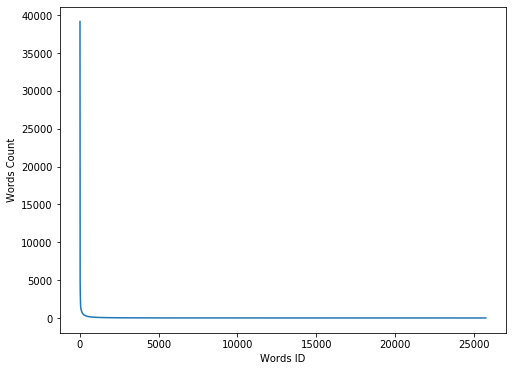

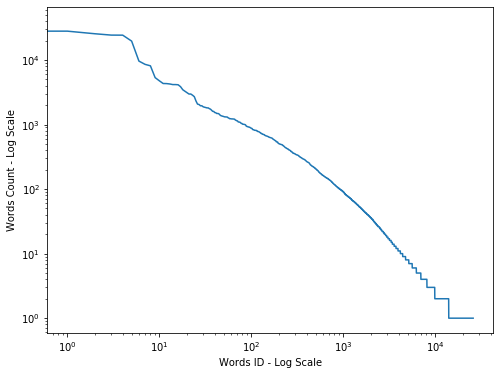

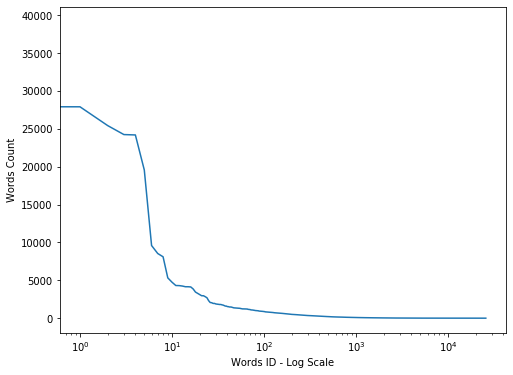

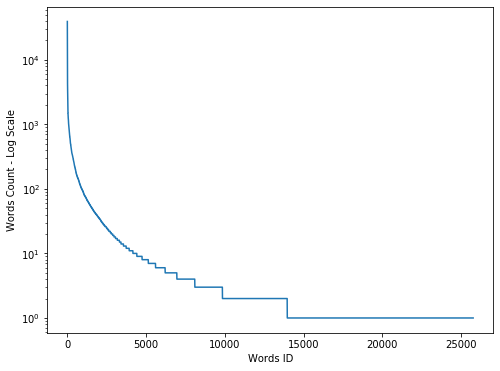

In [23]:
tokens_count = {}
for doc in docs_train:
    for token in doc:
        if (token in tokens_count):
            tokens_count[token] += 1
        else:
            tokens_count[token] = 1

tokens_count = {k: v for k, v in sorted(tokens_count.items(), key=lambda item: item[1], reverse=True)}

# your code goes here
plt.figure(figsize=(8,6))
plt.plot(list(tokens_count.values()))
plt.xlabel('Words ID')
plt.ylabel('Words Count')
plt.show()

plt.figure(figsize=(8,6))
plt.plot(list(tokens_count.values()))
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Words ID - Log Scale')
plt.ylabel('Words Count - Log Scale')
plt.show()

plt.figure(figsize=(8,6))
plt.plot(list(tokens_count.values()))
plt.xscale('log')
plt.xlabel('Words ID - Log Scale')
plt.ylabel('Words Count')
plt.show()

plt.figure(figsize=(8,6))
plt.plot(list(tokens_count.values()))
plt.yscale('log')
plt.xlabel('Words ID')
plt.ylabel('Words Count - Log Scale')
plt.show()


In [24]:
print("Different Words with (spacy) Stopwords:", len(tokens_count))
print("Top 10 Words with (spacy) Stopwords:", list(tokens_count.keys())[0:10])
print("Top 10 occurrences with (spacy) Stopwords:", list(tokens_count.values())[0:10])


Different Words with (spacy) Stopwords: 25774
Top 10 Words with (spacy) Stopwords: ['the', 'of', 'and', 'in', 'be', 'to', 'have', '-PRON-', 'a', 'for']
Top 10 occurrences with (spacy) Stopwords: [39174, 27927, 25444, 24258, 24207, 19578, 9598, 8543, 8111, 5326]


In [25]:
list_one_value = []
for i in tokens_count.values():
    if i == 1:
        list_one_value.append(i)

print('Number of words that occur exactly one time:', len(list_one_value))


Number of words that occur exactly one time: 11812


<h3 style="color:rgb(0,120,170)">Creating a dictionary</h3>
We create a dictionary by removing extremely frequent words and keeping the top <i>MAX_NB_WORDS=20000</i> words

In [26]:
dic = Dictionary(docs_train)
dic.filter_extremes(no_below=1, no_above=0.5, keep_n=MAX_NB_WORDS)
dic.compactify()
print("Total %s unique tokens." % len(dic))


Total 20000 unique tokens.


<h3 style="color:rgb(0,120,170)">Feature vectors of documents</h3>
Using the created dictionary, we first convert text documents to wordIDs and term counts.

In [27]:
docs_train_bow = [dic.doc2bow(_doc) for _doc in docs_train] 
docs_val_bow = [dic.doc2bow(_doc) for _doc in docs_val] 
docs_test_bow = [dic.doc2bow(_doc) for _doc in docs_test] 


# Exercise 3

- Take a look at the bag-of-word dictionary of the training ('docs_train_bow'). How many words does the longest dictionary entry have? How many word does the shortest dictionary entry have?

In [28]:
# Get longest and shortest dictionary entry:
for index, element in enumerate(docs_train_bow): # loop over the documents # index shows us the number of documents
    # element shows us ALL words with their tuples in one document

    if index == 0:
        maxi = len(element)
        max_dict = element
        max_index = index
        
    elif len(element) > maxi: 
        maxi = len(element)
        max_dict = element
        max_index = index
        
    if index == 0:
        mini = len(element)
        min_dict = element
        min_index = 0
        
    elif len(element) < mini:
        mini = len(element)
        min_dict = element
        min_index = index
        
print(f'The shortest dictionary entry has {mini} DIFFERENT words.')
print(f'The longest dictionary entry has {maxi} DIFFERENT words.')


The shortest dictionary entry has 4 DIFFERENT words.
The longest dictionary entry has 641 DIFFERENT words.


In [29]:
# Now get the number of words in the longest and shortest dictionary:
count_max = 0
for word in max_dict:
    count_max += word[1]
print(f'The longest dictionary entry has {count_max} words.')

count_min = 0
for word in min_dict:
    count_min += word[1]
print(f'The shortest dictionary entry has {count_min} words.')


The longest dictionary entry has 1857 words.
The shortest dictionary entry has 5 words.


<h3 style="color:rgb(0,120,170)">Creating TF-IDF vectors</h3>
To create the TF_IDF vectors, we train the TfidfModel model using the bag-of-word representations of training data

In [30]:
weight_model = TfidfModel(docs_train_bow)

docs_train_tfidf=[]
docs_val_tfidf=[]
docs_test_tfidf=[]

for _bow in docs_train_bow:
    docs_train_tfidf.append(weight_model[_bow])
for _bow in docs_val_bow:
    docs_val_tfidf.append(weight_model[_bow])
for _bow in docs_test_bow:
    docs_test_tfidf.append(weight_model[_bow])
    

<h3 style="color:rgb(0,120,170)">Dimensionality Reduction</h3>
Before training the models, we want to reduce the dimensionality of the TFIDF vector using the LSA method. <br>
We sparsify the TFIDF vectors, train an SVD model for dimensionality reduction, and reduce the dimension of the vectors.

In [31]:
docs_train_tfidf_sparse = np.zeros((len(docs_train_tfidf), MAX_NB_WORDS))
for doc_i, doc in enumerate(docs_train_tfidf):
    for item in doc:
        docs_train_tfidf_sparse[doc_i][item[0]] = item[1]
        

In [32]:
docs_val_tfidf_sparse = np.zeros((len(docs_val_tfidf), MAX_NB_WORDS))
for doc_i, doc in enumerate(docs_val_tfidf):
    for item in doc:
        docs_val_tfidf_sparse[doc_i][item[0]] = item[1]
        

In [33]:
docs_test_tfidf_sparse = np.zeros((len(docs_test_tfidf), MAX_NB_WORDS))
for doc_i, doc in enumerate(docs_test_tfidf):
    for item in doc:
        docs_test_tfidf_sparse[doc_i][item[0]] = item[1]
        

In [34]:
svd = sklearn.decomposition.TruncatedSVD(n_components=300)
svd.fit(docs_train_tfidf_sparse)


TruncatedSVD(algorithm='randomized', n_components=300, n_iter=5,
             random_state=None, tol=0.0)

At the block of svd my computer doen't work anymore or the kernel dies. I needed hours until it ran by accident.

In [35]:
vecs_train = svd.transform(docs_train_tfidf_sparse)


In [36]:
vecs_val = svd.transform(docs_val_tfidf_sparse)


In [37]:
vecs_test = svd.transform(docs_test_tfidf_sparse)


# Exercise 4

- Train different models to predict the labels of the test dataset: NaiveBayes, $k$-nearest neighbors (with $k$=10), and RandomForest (with n_estimators=100).
- Which classifier performs best?
- Plot the accuracy for each of the classifier
- Plot the per-class evaluation of the best classifier

In [38]:
def train(x, y, modelname):
 
    # your code goes here 
    if modelname=='NaiveBayes':
        clf = GaussianNB()
        
    elif modelname=='kNN':
        clf = KNeighborsClassifier(n_neighbors=10)
        
    elif modelname=='RandomForest':
        clf = RandomForestClassifier(n_estimators=100, random_state=1)
    
    else:
        print ('No definition for the model name %s!' % modelname)
        
    clf.fit(x, y) 
    
    return clf


In [39]:
modelnames = ['NaiveBayes', 'kNN','RandomForest']

# your code goes here
predictions = {}
for modelname in modelnames:
    print (modelname)
    model = train(vecs_train, labels_train, modelname)
    print (model)
    
    predictions[modelname] = model.predict(vecs_test) # do prediction on test set
    print (predictions[modelname])
    
print ('done!')


NaiveBayes
GaussianNB(priors=None, var_smoothing=1e-09)
[4 2 7 ... 8 9 2]
kNN
KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=10, p=2,
                     weights='uniform')
[4 7 7 ... 8 9 2]
RandomForest
RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=1, verbose=0,
                       warm_start=False)
[1 2 7 ... 8 9 2]
done!


In [40]:
results={}

# your code goes here
for modelname in predictions:
    print('\n###########################################################')
    print (modelname)
    results[modelname] = sklearn.metrics.classification_report(labels_test, predictions[modelname], output_dict=True)
    print (sklearn.metrics.classification_report(labels_test, predictions[modelname]))
    


###########################################################
NaiveBayes
              precision    recall  f1-score   support

           0       0.57      0.31      0.40        85
           1       0.63      0.38      0.47       124
           2       0.38      0.67      0.49       203
           3       0.65      0.37      0.47        82
           4       0.16      0.29      0.21        42
           5       0.11      0.85      0.19        20
           6       0.38      0.13      0.19        93
           7       0.80      0.55      0.65       223
           8       0.62      0.41      0.50       187
           9       0.77      0.62      0.69        60
          10       0.17      0.14      0.15        42
          11       0.33      0.41      0.36        39

    accuracy                           0.45      1200
   macro avg       0.46      0.43      0.40      1200
weighted avg       0.55      0.45      0.47      1200


###########################################################


RandomForest was with 0.60 the best classifier.

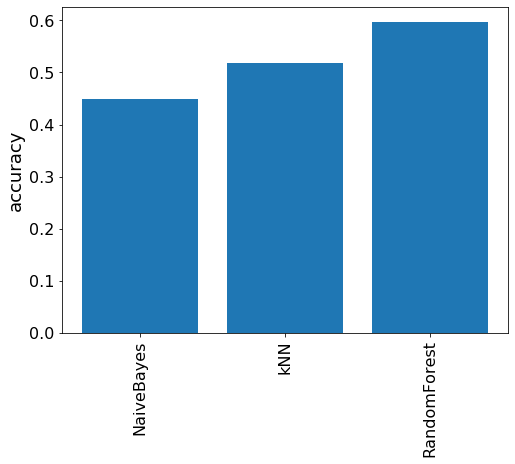

In [41]:
EVAL_MEASURE = 'accuracy'

# your code goes here
fig = plt.figure(figsize=(8,6)) 

_data_plot = [results[_modelname][EVAL_MEASURE] for _modelname in modelnames]

plt.bar(modelnames, _data_plot)
    
plt.ylabel(EVAL_MEASURE, fontsize=18)
plt.tick_params(axis='both', which='major', labelsize=16)
plt.tick_params(axis='both', which='minor', labelsize=12)
plt.xticks(rotation=90)

plt.show()


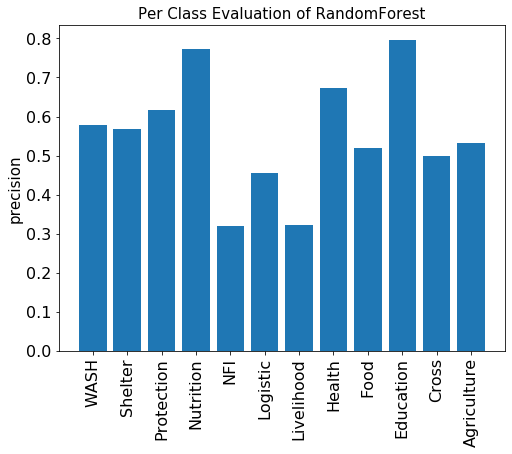

In [42]:
EVAL_MEASURE = 'precision'

MODEL_NAME = 'RandomForest'

fig = plt.figure(figsize=(8,6)) 

_labelids=[x for x in results[MODEL_NAME].keys()][:12]
_labeltexts=[]
_res = []
for _lid in _labelids:
    for _ltext in labelcaptions:
        if str(labelcaptions[_ltext])==_lid:
            _labeltexts.append(_ltext)
            
    _res.append(results[MODEL_NAME][_lid][EVAL_MEASURE])

plt.bar(_labeltexts, _res)
    
plt.title("Per Class Evaluation of %s" % (MODEL_NAME), fontsize=15)
plt.ylabel("%s" % (EVAL_MEASURE), fontsize=15)
plt.tick_params(axis='both', which='major', labelsize=16)
plt.tick_params(axis='both', which='minor', labelsize=12)

plt.xticks(rotation=90)
plt.show()
